# Case study to check MMS predictions

In [1]:
import os
from datetime import datetime
import math
import sys

import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools
import xarray as xr
import matplotlib as mpl
from tensorflow import keras

from aidapy import load_data
import aidapy.aidaxr

from scripts.tools import generate_output_path, standardize_ts, generate_train_test

In [2]:
url_tsc = 'https://osf.io/4d2yt/download'

try: 
    with open('data_set/mms1_samp_4dot5s_win_3min_pad_wrap.h5', 'xb') as r:
        html_tsc = requests.get(url_tsc)
        r.write(html_tsc.content)
except FileExistsError:
    print('TSC file has not been downloaded, file already exists')

TSC file has not been downloaded, file already exists


In [3]:
# function that reindexes on dataset's lowest sampling frequency
def reindex_ds_on_lowest_sampling(data):

    time_ind = []
    data_ind = []
    for data_prod in data.indexes:
        if isinstance(data.indexes[data_prod], pd.DatetimeIndex):
            time_ind.append(len(data.indexes[data_prod]))
            data_ind.append(data_prod)

    smallest_data_obj = data[data_ind[int(np.argmin(time_ind))]]
    time = smallest_data_obj.rename({smallest_data_obj.name: 'time'})

    for i_time, data_obj in enumerate(data):
        data[data_obj] = data[data_obj].rename({'time'+str(i_time+1): 'time'}).reindex({'time': time}, method='nearest')
        data = data.drop('time'+str(i_time+1))

    return data

In [4]:
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [5]:
# Import information on data and training
ml_method = 'tsc' # tsc, mlp
data_version = 'mms1_samp_4dot5s_win_3min_pad_wrap' 
data_process = 'no_flux_shuffle_znorm' 
classifier_name = 'fcn'
period = '2016_2018'

x_train, y_train, x_test, y_test, x_val, y_val = generate_train_test(ml_method, data_version, data_process.replace('znorm',''), period)

if ml_method == 'tsc':
    model_path = os.path.join('trained_model', 'fcn','best_model.hdf5')
    model = keras.models.load_model(model_path)
else:
    raise ValueError('Not implemented')

## Load data from aidapy

In [6]:
## dayside use case
start_time = datetime(2019, 11, 9, 0, 0, 0)
end_time = datetime(2019, 11, 9, 23, 59, 0)

## nighstide use case
#start_time = datetime(2019, 7, 13, 0, 0, 0)
#end_time = datetime(2019, 7, 13, 23, 0, 0)

settings = {'prod': ['dc_mag', 'i_dens', 'i_bulkv', 'i_omniflux', 'i_energy', 'i_temppara', 'i_tempperp'], 'probes': ['1'], 'coords': 'gse'}

data = load_data('mms', start_time, end_time, **settings)
# reshape dataset
data = reindex_ds_on_lowest_sampling(data)
print(data)

/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/heliopy/data/util.py:577: UserWarning: The CDF provided units ('hours') for key 'mms1_mec_mlt' are unknown
  warnings.warn(message)
/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/heliopy/data/util.py:577: UserWarning: The CDF provided units ('hours') for key 'mms1_mec_mlt' are unknown
  warnings.warn(message)
/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/heliopy/data/util.py:577: UserWarning: The CDF provided units ('hours') for key 'mms1_mec_mlt' are unknown
  warnings.warn(message)
/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/heliopy/data/util.py:577: UserWarning: The CDF provided units ('hours') for key 'mms1_mec_mlt' are unknown
  warnings.warn(message)
/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/heliopy/data/util.py:577: UserWarning: The CDF provided units ('hours') for key 'mms1_mec_mlt' ar

<xarray.Dataset>
Dimensions:                          (mms1_dis_bulkv_gse_fast: 3, mms1_dis_energy_fast: 32, mms1_dis_energyspectr_omni_fast: 32, mms1_fgm_b_gse_srvy_l2: 4, time: 15238)
Coordinates:
  * mms1_fgm_b_gse_srvy_l2           (mms1_fgm_b_gse_srvy_l2) <U3 'x' ... 'tot'
  * mms1_dis_bulkv_gse_fast          (mms1_dis_bulkv_gse_fast) <U1 'x' 'y' 'z'
  * mms1_dis_energyspectr_omni_fast  (mms1_dis_energyspectr_omni_fast) int64 0 ... 31
  * mms1_dis_energy_fast             (mms1_dis_energy_fast) int64 0 1 ... 30 31
  * time                             (time) datetime64[ns] 2019-11-09T04:56:10.799317 ... 2019-11-09T23:58:57.896904
Data variables:
    dc_mag1                          (time, mms1_fgm_b_gse_srvy_l2) float32 -23.07074 ... 5.9903297
    i_dens1                          (time) float32 1.0617173 ... 5.487746
    i_bulkv1                         (time, mms1_dis_bulkv_gse_fast) float32 10.643942 ... 13.264574
    i_omniflux1                      (time, mms1_dis_energyspectr_o

In [7]:
data = data.sel(time=slice(start_time, end_time))
omni_flux = data['i_omniflux1'].transpose()
energy = data['i_energy1'].data[0,:]
omni_flux.coords['mms1_dis_energyspectr_omni_fast'] = energy

pos_gse = data['dc_mag1'].attrs['pos_gse']
_, index = np.unique(pos_gse['time'], return_index=True)
pos_gse = pos_gse.isel(time=index)

sc_pos = pos_gse.reindex_like(data['dc_mag1'], method='nearest')
#sc_pos = data['dc_mag1'].attrs['pos_gse'].reindex_like(data['dc_mag1'], method='nearest')
x_pos = sc_pos.data[:, 0]/6378
y_pos = sc_pos.data[:, 1]/6378
z_pos = sc_pos.data[:, 2]/6378

df_dc_mag = data['dc_mag1'].to_pandas()
df_dc_mag['tot'] = np.linalg.norm(df_dc_mag.values, axis=1)
df_i_dens = data['i_dens1'].to_pandas()
df_i_bulkv = data['i_bulkv1'].to_pandas()
df_i_bulkv['tot'] = np.linalg.norm(df_i_bulkv.values, axis=1)
df_i_temp = pd.concat([data['i_temppara1'].to_pandas(), data['i_tempperp1'].to_pandas()], axis=1)
df_i_temp['tot'] = df_i_temp.mean(axis=1)
df_final = pd.concat([df_dc_mag, df_i_dens, df_i_bulkv, df_i_temp], axis=1)
df_final.columns = ['bx', 'by', 'bz', 'btot', 'n', 'vx', 'vy', 'vz', 'vtot', 'tpara', 'tperp', 'ttot']
df_final.head()

,bx,by,bz,btot,n,vx,vy,vz,vtot,tpara,tperp,ttot
time,,,,,,,,,,,,
2019-11-09 04:56:10.799317,-23.070740,-11.518753,49.310375,78.695030,1.061717,10.643942,-3.121374,11.397687,15.904205,3723.028564,4685.095215,4204.062012
2019-11-09 04:56:15.299351,-23.066311,-11.324245,49.328667,78.658890,1.007311,3.492620,-20.201084,6.871820,21.621843,3797.230469,4790.664062,4293.947266
2019-11-09 04:56:19.799379,-22.995838,-11.582796,49.376778,78.753227,1.127714,2.313490,-26.922585,10.727158,29.073177,3469.685059,4403.700195,3936.692627
2019-11-09 04:56:24.299413,-23.128809,-11.511268,49.353592,78.781067,1.120203,12.988611,-19.751074,6.253063,24.452194,3505.093506,4323.500488,3914.296875
2019-11-09 04:56:28.799441,-23.080652,-11.633355,49.356796,78.792702,1.079665,11.099345,-11.874781,10.330395,19.259359,3607.048096,4542.849121,4074.948730


In [8]:
block_size = 40
blocks = list(more_itertools.chunked(df_final.values, block_size))
blocks = [np.array(x) for x in blocks]

x_input = np.array(blocks[:-1])

timestamps = list(more_itertools.chunked(df_final.index, block_size))
timestamps = np.array(timestamps[:-1])

index = pd.DatetimeIndex(timestamps[:, 0])

## Load labels from SC location to compare with predictions

In [9]:
# resample also sc location
sc_pos = pos_gse.reindex_like(data.dc_mag1, method='nearest')

#define input data arrays
r_x = sc_pos.data[:,0]/6378 # in Re
r_y = sc_pos.data[:,1]/6378 # in Re
r_z = sc_pos.data[:,2]/6378 # in Re
b_tot = np.linalg.norm(data.dc_mag1.data, axis=1)
#n_i = data.i_dens3.data
labels = np.empty((len(data.time)), dtype='object')

In [10]:
""" Param plasmasphère : fce > 3
    Param vent solaire : (xgse > 14) 
    Param tail : xgse > -10 & -12 < y/zgse < 12 & fce < 1
    Param gaine : fce < 3 & 4 < xgse < 6 """
# regions:
#SW, TL, MS, PL
# initiale : np.where((tmp_fce < 0.7) & (tmp_xgse < 6) & (tmp_xgse > 2))[0]
labels_dict = {'MS': (b_tot < 30) & (b_tot > 5) & (r_x < 14) & (r_x > 8),
               'TL': (r_x < -10) & (r_y < 12) & (r_y > -12) & (r_z < 12) & (r_z > -12) & (b_tot < 30),
               'PL': b_tot > 100,
               'SW': r_x > 14}

In [11]:
for i, arr in enumerate(labels_dict.values()):
    labels[arr] = i+1
ind = np.where(labels == None)[0]
labels[ind] = '0'
labels = labels.astype(int)

labels = list(more_itertools.chunked(labels, block_size))
labels = np.array(labels[:-1])
labels = pd.DataFrame(labels[:, 0])
labels = labels.set_index(index)
labels.head()

,0
2019-11-09 04:56:10.799317,0
2019-11-09 04:59:10.800550,0
2019-11-09 05:02:10.801793,0
2019-11-09 05:05:10.803060,0
2019-11-09 05:08:10.804354,0


## Load model and predict classes and probability

In [12]:
# normalize to train set

model.summary()
x_input = standardize_ts(x_input, x_train)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 12)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 256)           24832     
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 40, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 512)           655872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 512)           2048      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 512)           0     

In [13]:
y_prob = model.predict(x_input) 
y_classes = y_prob.argmax(axis=-1)

In [14]:
y_classes = pd.DataFrame(y_classes)
y_classes = y_classes.set_index(index)
y_classes.head()

,0
2019-11-09 04:56:10.799317,6
2019-11-09 04:59:10.800550,6
2019-11-09 05:02:10.801793,6
2019-11-09 05:05:10.803060,6
2019-11-09 05:08:10.804354,6


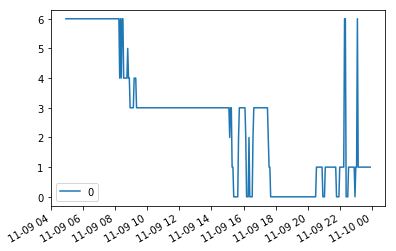

In [15]:
y_classes.plot()

In [16]:
labels = labels.loc[start_time:end_time]

y_classes = y_classes.loc[start_time:end_time]

## Eyeball the different classifications

/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


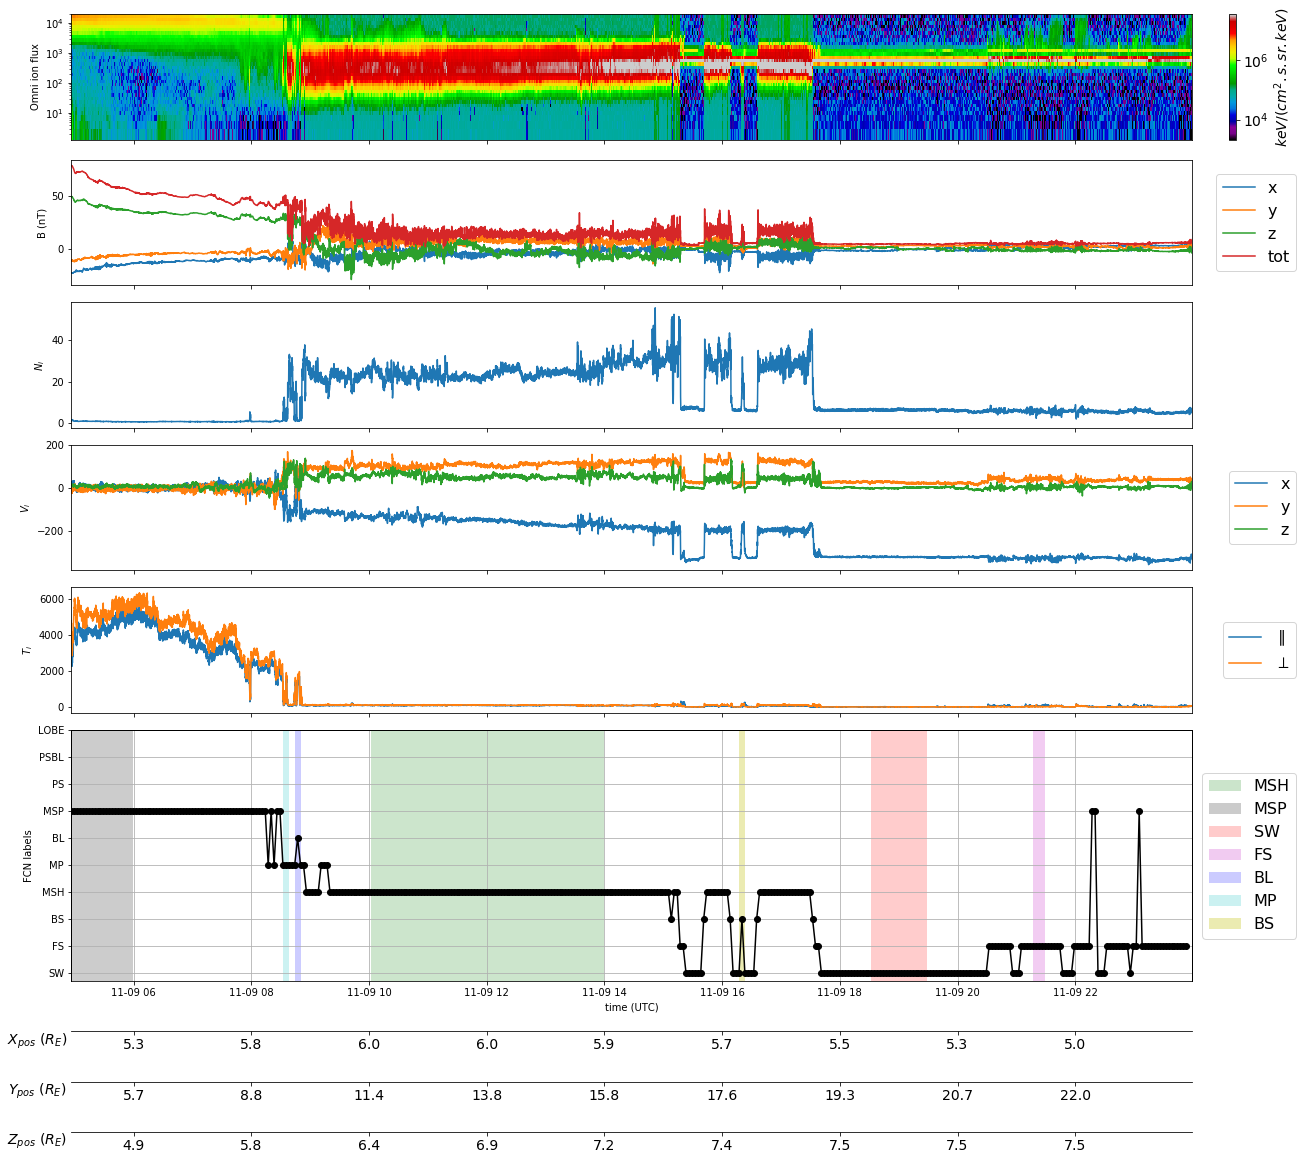

In [17]:
# Define widths and heights of subplots
widths = [1]
heights = [1, 1, 1, 1, 1, 2]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1,figsize=(18, 16), sharex=True, constrained_layout=True, gridspec_kw=gs_kw)
#fig.suptitle('Prediction: Class '+str(y_classes[0]))

size=14
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size+2)    # legend fontsize
plt.rc('figure', titlesize=size)  # fontsize of the figure title

#parasite.axis["right"].major_ticklabels.set_visible(True)
#parasite.axis["right"].label.set_visible(True)

im1 = xr.plot.pcolormesh(np.log10(omni_flux), yscale = 'log', cmap='nipy_spectral', add_colorbar=False, ax=ax1, robust=True)

#divider = make_axes_locatable(ax1)
#ax2 = divider.append_axes("bottom", size="50%", pad=0.08)
#ax3 = divider.append_axes("bottom", size="50%", pad=0.08)
#ax4 = divider.append_axes("bottom", size="50%", pad=0.08)
#ax5 = divider.append_axes("bottom", size="50%", pad=0.08)
#ax6 = divider.append_axes("bottom", size="50%", pad=0.08)
#ax7 = divider.append_axes("bottom", size="50%", pad=0.08)
#cax = divider.append_axes("right", size="5%", pad=0.08)
#cb = plt.colorbar( im, ax=ax1, cax=cax )

cb = plt.colorbar(im1, ax=ax1)
cb_ticks = list(mpl.colorbar.ColorbarBase.get_ticks(cb))
cb_ticks = ["10$^{}$".format(int(x)) for x in cb_ticks]
cb.ax.set_yticklabels(cb_ticks)
cb.set_label(r"$keV/(cm^2.s.sr.keV)$")
ax1.set_ylabel(r"Omni ion flux")
ax1.set_xlabel('')

data['dc_mag1'].plot.line(x='time', ax=ax2)
ax2.legend(('x','y','z', 'tot'), bbox_to_anchor=(1.1, 0.5), loc='right')
ax2.set_ylabel(r"B (nT)")
ax2.set_xlabel('')
data['i_dens1'].plot(ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel(r"$N_i~(cm^{-3})$")
data['i_bulkv1'].plot.line(x='time', ax=ax4)
ax4.legend(('x','y','z'),bbox_to_anchor=(1.1, 0.5), loc='right')
ax4.set_ylabel(r"$V_i~(km/s)$")
ax4.set_xlabel('')
data['i_temppara1'].plot(ax=ax5, label=r"$\parallel$")
data['i_tempperp1'].plot(ax=ax5, label=r"$\perp$")
ax5.legend(bbox_to_anchor=(1.1, 0.5), loc='right')
ax5.set_ylabel(r"$T_i~(eV)$")
ax5.set_xlabel('')
ax6.plot(y_classes, '-ok') # CNN classifier: 0:MP, 1:MS, 2:TL, 3:BS, 4:SW
ax6.yaxis.set_ticks(np.arange(0,10,1))
ax6.yaxis.set_ticklabels(['SW', 'FS', 'BS', 'MSH', 'MP', 'BL', 'MSP', 'PS', 'PSBL', 'LOBE'])
ax6.set_ylabel('FCN labels')
ax6.set_xlabel('time (UTC)')
ax6.grid()


x_min, x_max = ax6.get_xlim()
ticks_pos = [(tick - x_min)/(x_max - x_min) for tick in ax6.get_xticks()]
 
ax7 = ax6.twiny()
ax8 = ax6.twiny()
ax9 = ax6.twiny()

# Add some extra space for the second axis at the bottom
# Move twinned axis ticks and label from top to bottom
ax7.xaxis.set_ticks_position("bottom")
ax7.xaxis.set_label_position("bottom")
ax8.xaxis.set_ticks_position("bottom")
ax8.xaxis.set_label_position("bottom")
ax9.xaxis.set_ticks_position("bottom")
ax9.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax7.spines["bottom"].set_position(("axes", -0.2))
ax8.spines["bottom"].set_position(("axes", -0.4))
ax9.spines["bottom"].set_position(("axes", -0.6))

# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
#ax8.set_frame_on(True)
#ax8.patch.set_visible(False)
# for sp in ax8.spines.items():
#     sp.set_visible(False)
# ax8.spines["bottom"].set_visible(True)

ax7.set_xticks(ticks_pos)
ax7.set_xticklabels([truncate(tick, 1) for tick in x_pos[::len(x_pos)//len(ax6.get_xticks())][:10]])
ax7.set_xlabel(r"$X_{pos}$ $(R_E)$")
ax7.xaxis.set_label_coords(-0.03,-0.2)

ax8.set_xticks(ticks_pos)
ax8.set_xticklabels([truncate(tick, 1) for tick in y_pos[::len(y_pos)//len(ax6.get_xticks())][:10]])
ax8.set_xlabel(r"$Y_{pos}$ $(R_E)$")
ax8.xaxis.set_label_coords(-0.03,-0.4)

ax9.set_xticks(ticks_pos)
ax9.set_xticklabels([truncate(tick, 1) for tick in z_pos[::len(z_pos)//len(ax6.get_xticks())][:10]])
ax9.set_xlabel(r"$Z_{pos}$ $(R_E)$")
ax9.xaxis.set_label_coords(-0.03,-0.6)

# # dayside use case
msh_true = y_classes.loc['2019-11-09 10:00' : '2019-11-09 14:00'].index
ax6.axvspan(msh_true[0], msh_true[-1], facecolor = 'g', alpha=0.2, label='MSH')

msp_true = y_classes.loc['2019-11-09 00:00' : '2019-11-09 06:00'].index
ax6.axvspan(msp_true[0], msp_true[-1], facecolor = 'k', alpha=0.2, label='MSP')

sw_true = y_classes.loc['2019-11-09 18:30' : '2019-11-09 19:30'].index
ax6.axvspan(sw_true[0], sw_true[-1], facecolor = 'r', alpha=0.2, label='SW')

fs_true = y_classes.loc['2019-11-09 21:15' : '2019-11-09 21:30'].index
ax6.axvspan(fs_true[0], fs_true[-1], facecolor = 'm', alpha=0.2, label='FS')

bl_true = y_classes.loc['2019-11-09 08:42' : '2019-11-09 08:52'].index
ax6.axvspan(bl_true[0], bl_true[-1], facecolor = 'b', alpha=0.2, label='BL')

mp_true = y_classes.loc['2019-11-09 08:32' : '2019-11-09 08:40'].index
ax6.axvspan(mp_true[0], mp_true[-1], facecolor = 'c', alpha=0.2, label='MP')

bs_true = y_classes.loc['2019-11-09 16:17' : '2019-11-09 16:23'].index
ax6.axvspan(bs_true[0], bs_true[-1], facecolor = 'y', alpha=0.3, label='BS')

ax6.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

#nightside use case
# msp_true = y_classes.loc['2019-07-13 00:00' : '2019-07-13 02:00'].index
# ax6.axvspan(msp_true[0], msp_true[-1], facecolor = 'k', alpha=0.2, label='MSP')

# lobe_true = y_classes.loc['2019-07-13 09:15' : '2019-07-13 09:45'].index
# ax6.axvspan(lobe_true[0], lobe_true[-1], facecolor = 'b', alpha=0.2, label='LOBE')

# ps_true = y_classes.loc['2019-07-13 16:40' : '2019-07-13 17:00'].index
# ax6.axvspan(ps_true[0], ps_true[-1], facecolor = 'g', alpha=0.2, label='PS')

# psbl_true = y_classes.loc['2019-07-13 21:00' : '2019-07-13 22:00'].index
# ax6.axvspan(psbl_true[0], psbl_true[-1], facecolor = 'r', alpha=0.2, label='PSBL')

# ax6.legend(bbox_to_anchor=(1.1, 0.5), loc='right')